# A variational autoencoder

In [17]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Lambda, Input, Dense
#from tensorflow.keras.models import Model
from keras import Model

from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import tensorflow as tf

from keras.models import Sequential
from keras.layers import *
from keras import layers, models

def to_functional_model(seqmodel):
    input_layer = Input(batch_shape=seqmodel.layers[0].input_shape)
    prev_layer = input_layer
    for layer in seqmodel.layers:
        prev_layer = layer(prev_layer)
    output_layer = prev_layer
    funcmodel = models.Model([input_layer], [prev_layer])
    return input_layer, output_layer, funcmodel

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def get_vae_loss(inputs, outputs, z_mean, z_log_var, reconstruction_loss = "mse", original_dim = 130, impact_reconstruction_loss = 1, impact_kl_loss = 1):
    # VAE loss = mse_loss or binary_crossentropy + kl_loss
    if reconstruction_loss == "binary_crossentropy":
        reconstruction_loss = binary_crossentropy(inputs,outputs)
    elif reconstruction_loss == "mse":
        reconstruction_loss = mse(inputs, outputs)

    reconstruction_loss *= original_dim
    
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(K.mean(impact_reconstruction_loss*reconstruction_loss) + impact_kl_loss * K.mean(kl_loss))
    return vae_loss

def image_encoder():
    image_model = Sequential()
    image_model.add(Conv2D(32, (8, 8), subsample=(4, 4), input_shape=[50, 50, 1], activation = "relu"))
    image_model.add(Conv2D(64, (4, 4), subsample=(2, 2), activation = "relu"))
    image_model.add(Conv2D(64, (3, 3), subsample=(1, 1), activation = "relu"))
    image_model.add(Flatten())
    image_model.add(Dense(512, activation = "relu"))
    image_model.add(Dense(256, activation = "relu"))
    image_model.add(Dense(64, activation = "relu"))

    image_input, image_output, image_model = to_functional_model(image_model)
    return image_input, image_output

def encoder():
    image_input, image_output = image_encoder()
    z_mean = Dense(2, name='z_mean')(image_output)
    z_log_var = Dense(2, name='z_log_var')(image_output)
    z = Lambda(sampling, output_shape=(2,), name='z')([z_mean, z_log_var])
    return image_input, [z_mean, z_log_var, z]

def image_decoder(encoded):
    shape = [-1,16,16, 1]
    x = Dense(256, activation = "relu")(encoded)
    x = Dense(256, activation = "relu")(encoded)
    x = Reshape((shape[1], shape[2], shape[3]))(x)
    x = layers.Conv2D(8, (6, 6), activation='relu', padding = "same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(5, (6, 6), activation='relu')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(1, (5, 5), activation='relu')(x)
    return x


def decoder():
    latent_inputs = Input(shape=(2,), name='z_sampling')
    image_decoded = image_decoder(latent_inputs)
    return latent_inputs, image_decoded

In [22]:
image_input, [z_mean, z_log_var, z] = encoder()
latent_inputs, image_decoded = decoder()
encoder_model = Model(inputs = image_input, outputs = [z_mean, z_log_var, z], name = "encoder")
decoder_model = Model(inputs = latent_inputs, outputs = image_decoded, name='decoder')

/home/elerator/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (8, 8), input_shape=[50, 50, 1..., activation="relu", strides=(4, 4))`
/home/elerator/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), activation="relu", strides=(2, 2))`
/home/elerator/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", strides=(1, 1))`


In [23]:
image_decoded.shape

TensorShape([None, 50, 50, 1])

In [24]:
image_decoded = decoder_model(encoder_model(image_input)[2])

In [25]:
vae = Model(inputs = image_input, outputs = image_decoded, name='vae_cnn')

In [26]:
import keras
vae.add_loss(get_vae_loss(image_input, image_decoded, z_mean, z_log_var, impact_reconstruction_loss = 1, impact_kl_loss = 0))
vae.compile(optimizer = "adam")

/home/elerator/anaconda3/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


# Load dataset

In [27]:
import numpy as np
import os
from sklearn.model_selection import train_test_split

dataset_folder = "texture_datasets"
source_patches = np.load(os.path.join(dataset_folder,"source_patches.npy"))
labels = np.load(os.path.join(dataset_folder,"labels.npy"))

In [28]:
x_train, x_test, y_train, y_test = train_test_split(source_patches, labels, test_size = 0.2, random_state=42)

In [29]:
x_train = np.expand_dims(x_train, -1)
y_train = np.expand_dims(y_train, -1)

In [30]:
x_train.shape

(35528, 50, 50, 1)

In [31]:
batch_size = 100

In [32]:
history = vae.fit(x_train[:1000], epochs = 200, batch_size=batch_size, verbose=1)

Epoch 1/200
1000/1000 [==============================] - 9s 9ms/step - loss: 30.0952
Epoch 2/200
1000/1000 [==============================] - 3s 3ms/step - loss: 16.7363
Epoch 3/200
1000/1000 [==============================] - 3s 3ms/step - loss: 8.6576
Epoch 4/200
1000/1000 [==============================] - 3s 3ms/step - loss: 6.1902
Epoch 5/200
1000/1000 [==============================] - 3s 3ms/step - loss: 5.2286
Epoch 6/200
1000/1000 [==============================] - 3s 3ms/step - loss: 4.6857
Epoch 7/200
1000/1000 [==============================] - 3s 3ms/step - loss: 4.2444
Epoch 8/200
1000/1000 [==============================] - 3s 3ms/step - loss: 4.0452
Epoch 9/200
1000/1000 [==============================] - 3s 3ms/step - loss: 3.8978
Epoch 10/200
1000/1000 [==============================] - 3s 3ms/step - loss: 3.8262
Epoch 11/200
1000/1000 [==============================] - 3s 3ms/step - loss: 3.7648
Epoch 12/200
1000/1000 [==============================] - 3s 3ms/step - 

1000/1000 [==============================] - 2s 2ms/step - loss: 3.4556
Epoch 98/200
1000/1000 [==============================] - 3s 3ms/step - loss: 3.4563
Epoch 99/200
1000/1000 [==============================] - 3s 3ms/step - loss: 3.4569
Epoch 100/200
1000/1000 [==============================] - 3s 3ms/step - loss: 3.4568
Epoch 101/200
1000/1000 [==============================] - 2s 2ms/step - loss: 3.4609
Epoch 102/200
1000/1000 [==============================] - 2s 2ms/step - loss: 3.4638
Epoch 103/200
1000/1000 [==============================] - 2s 2ms/step - loss: 3.4590
Epoch 104/200
1000/1000 [==============================] - 3s 3ms/step - loss: 3.4602
Epoch 105/200
1000/1000 [==============================] - 3s 3ms/step - loss: 3.4551
Epoch 106/200
1000/1000 [==============================] - 3s 3ms/step - loss: 3.4544
Epoch 107/200
1000/1000 [==============================] - 2s 2ms/step - loss: 3.4517
Epoch 108/200
1000/1000 [==============================] - 2s 2ms/step

1000/1000 [==============================] - 2s 2ms/step - loss: 3.3959
Epoch 193/200
1000/1000 [==============================] - 3s 3ms/step - loss: 3.3925
Epoch 194/200
1000/1000 [==============================] - 3s 3ms/step - loss: 3.3865
Epoch 195/200
1000/1000 [==============================] - 3s 3ms/step - loss: 3.3909
Epoch 196/200
1000/1000 [==============================] - 2s 2ms/step - loss: 3.3949
Epoch 197/200
1000/1000 [==============================] - 2s 2ms/step - loss: 3.3884
Epoch 198/200
1000/1000 [==============================] - 3s 3ms/step - loss: 3.3872
Epoch 199/200
1000/1000 [==============================] - 3s 3ms/step - loss: 3.4016
Epoch 200/200
1000/1000 [==============================] - 3s 3ms/step - loss: 3.3985


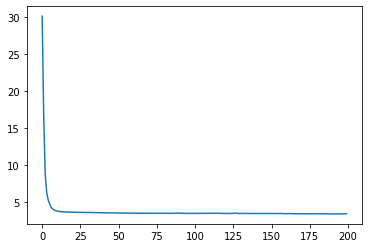

In [33]:
import matplotlib.pyplot as plt
plt.plot(vae.history.history["loss"])

In [35]:
history = vae.fit(x_train[1000:2000], epochs=100, batch_size=batch_size, verbose=1)

Epoch 1/100
1000/1000 [==============================] - 3s 3ms/step - loss: 3.3698
Epoch 2/100
1000/1000 [==============================] - 3s 3ms/step - loss: 3.3806
Epoch 3/100
1000/1000 [==============================] - 3s 3ms/step - loss: 3.3809
Epoch 4/100
1000/1000 [==============================] - 3s 3ms/step - loss: 3.3565
Epoch 5/100
1000/1000 [==============================] - 2s 2ms/step - loss: 3.3595
Epoch 6/100
1000/1000 [==============================] - 3s 3ms/step - loss: 3.3576
Epoch 7/100
1000/1000 [==============================] - 3s 3ms/step - loss: 3.3474
Epoch 8/100
1000/1000 [==============================] - 3s 3ms/step - loss: 3.3450
Epoch 9/100
1000/1000 [==============================] - 3s 3ms/step - loss: 3.3501
Epoch 10/100
1000/1000 [==============================] - 3s 3ms/step - loss: 3.3449
Epoch 11/100
1000/1000 [==============================] - 4s 4ms/step - loss: 3.3430
Epoch 12/100
1000/1000 [==============================] - 5s 5ms/step - lo

1000/1000 [==============================] - 4s 4ms/step - loss: 3.3304
Epoch 98/100
1000/1000 [==============================] - 5s 5ms/step - loss: 3.3255
Epoch 99/100
1000/1000 [==============================] - 5s 5ms/step - loss: 3.3341
Epoch 100/100
1000/1000 [==============================] - 4s 4ms/step - loss: 3.3305


In [ ]:
history = vae.fit(x_train, epochs = 70, batch_size=batch_size, verbose=1)

In [ ]:
plt.plot(vae.history.history["loss"])

In [ ]:
# train the autoencoder
#history = vae.fit(x_train, epochs=epochs, batch_size=batch_size, verbose=1)

In [ ]:
from scipy.stats import gaussian_kde

In [ ]:
fig, ax = plt.subplots(1,2)

res_pos_ex = encoder_model.predict(x_train[y_train[:,0]])[2]
xy = np.vstack([res_pos_ex.T[0], res_pos_ex.T[1]])
z = gaussian_kde(xy)(xy)
ax[0].scatter(res_pos_ex.T[0], res_pos_ex.T[1], c = z, edgecolor = "")
xrange = [np.min(res_pos_ex.T[0]), np.max(res_pos_ex.T[0])]
yrange = [np.min(res_pos_ex.T[1]), np.max(res_pos_ex.T[1])]


res_neg_ex = encoder_model.predict(x_train[~y_train[:,0]])[2]
xy = np.vstack([res_neg_ex.T[0], res_neg_ex.T[1]])
z = gaussian_kde(xy)(xy)
ax[1].scatter(res_neg_ex.T[0], res_neg_ex.T[1], c = z, edgecolor = "")
xrange = [np.min(res_neg_ex.T[0]), np.max(res_neg_ex.T[0])]
yrange = [np.min(res_neg_ex.T[1]), np.max(res_neg_ex.T[1])]


ax[0].set_xlim(xrange)
ax[0].set_ylim(yrange)
ax[0].set_aspect(1)

ax[1].set_xlim(xrange)
ax[1].set_ylim(yrange)
ax[1].set_aspect(1)

res = encoder_model.predict(x_train)[2]
xrange = [np.percentile(res.T[0], 1), np.percentile(res.T[0], 99)]
yrange = [np.percentile(res.T[1], 1), np.percentile(res.T[1], 99)]

In [ ]:
nbins = 25
bins = [np.linspace(xrange[0],xrange[1], nbins), np.linspace(yrange[0], yrange[1], nbins)]
pos, neg = [np.histogram2d(res_neg_ex.T[0], res_neg_ex.T[1], bins = bins, density = False), 
                            np.histogram2d(res_pos_ex.T[0], res_pos_ex.T[1], bins = bins, density = False)]

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (10,10))
ax[1].imshow(np.flipud(pos[0]), cmap = "viridis")
ax[0].imshow(np.flipud(neg[0]), cmap = "viridis")
ax[2].imshow(np.flipud(pos[0]-neg[0]), cmap = "seismic")

In [ ]:
pos[0].shape

In [ ]:
#res = encoder_model.predict(x_train)[2]

In [ ]:
fig, ax = plt.subplots(1)

ax.scatter(res.T[0][~y_train[:,0]], res.T[1][~y_train[:,0]], c = "yellow", edgecolor = "", s = 5, label = "full")
ax.scatter(res.T[0][y_train[:,0]], res.T[1][y_train[:,0]], c = "blue", edgecolor = "", s = 1, label = "empty")
ax.legend()

xrange = [np.percentile(res.T[0], 1), np.percentile(res.T[0], 99)]
yrange = [np.percentile(res.T[1], 1), np.percentile(res.T[1], 99)]
ax.set_xlim(xrange)
ax.set_ylim(yrange)

In [ ]:
def fig2rgb_array(fig):
    """ Converts a matplotlib figure to an rgb array such that it may be displayed as an ImageDisplay
    Args:
        fig: Matplotlib figure
    Returns:
        arr: Image of the plot in the form of a numpy array
    """
    fig.canvas.draw()
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    return np.fromstring(buf, dtype=np.uint8).reshape(nrows, ncols, 3)

In [ ]:
n = 25
xs = np.linspace(xrange[0],xrange[1],n)
ys = np.linspace(yrange[0],yrange[1],n)

In [ ]:
test = np.array([[0,0,0],[0,0,0]]).T

In [ ]:
fig, ax = plt.subplots(n,n, figsize= (n,n))
plt.subplots_adjust(0,0,1,1,.05,.05)
for i in range(len(list(ax))):
    for i1 in range(len(list(ax)[0])):
        ax[i, i1].axis("off")
        curr_y, curr_x = xs[i1], ys[len(ys)-1-i]
        pred = decoder_model.predict(np.array([[curr_y,  curr_x]]))[0,:,:,0]
        ax[i, i1].imshow(pred, vmin = .25, vmax = .75)
manifold = fig2rgb_array(fig)

In [ ]:
fig = plt.figure(constrained_layout=True, figsize = (10,8), dpi = 300)
gs = fig.add_gridspec(nrows=4, ncols=6, left=0.0, right=1, wspace = 0, hspace = 0)
ax = []
ax.append(fig.add_subplot(gs[:3, :3]))
ax.append(fig.add_subplot(gs[:3, 3:]))
ax.append(fig.add_subplot(gs[3, 0:2]))
ax.append(fig.add_subplot(gs[3, 2:4]))
ax.append(fig.add_subplot(gs[3, 4:6]))
#fig, ax = plt.subplots(1,2, figsize = (10,10), dpi = 300)

xrange = [np.percentile(res.T[0], 1), np.percentile(res.T[0], 99)]
yrange = [np.percentile(res.T[1], 1), np.percentile(res.T[1], 99)]
ax[1].set_xlim(xrange[0]-.05,xrange[1]+.05)
ax[1].set_ylim(yrange)

ax[1].scatter(res.T[0][~y_train[:,0]], res.T[1][~y_train[:,0]], c = "red", edgecolor = "", s = 1, label = "full")
ax[1].scatter(res.T[0][y_train[:,0]], res.T[1][y_train[:,0]], c = "blue", edgecolor = "", s = 1, label = "empty")
ax[1].legend()

ax[0].imshow(manifold)
ax[0].set_aspect(1)

ax[0].set_xticks(np.linspace(manifold.shape[0]/25/2, manifold.shape[0]-manifold.shape[0]/25/2, 6))
ax[0].set_yticks(np.linspace(manifold.shape[0]/25/2, manifold.shape[0]-manifold.shape[0]/25/2, 6))
print([np.round(x,1) for x in np.linspace(xrange[0], xrange[1], 6)])
ax[0].set_xticklabels([np.round(x,1) for x in np.linspace(xrange[0], xrange[1], 6)])
ax[0].set_yticklabels([np.round(x,1) for x in np.linspace(xrange[0], xrange[1], 6)])

for a in ax:
    a.set_xlabel("z [0]")
    a.set_ylabel("z [1]")
ax[0].set_aspect(1)
ax[1].set_aspect(1)



ax[1].set_xlabel("z [0]")
ax[1].set_ylabel("z [1]")

ax[3].imshow(np.flipud(pos[0]), cmap = "viridis")
ax[2].imshow(np.flipud(neg[0]), cmap = "viridis")
ax[4].imshow(np.flipud(pos[0] - neg[0]), cmap = "seismic")

In [ ]:
from PIL import Image
from sklearn.feature_extraction.image import extract_patches_2d

arr = np.array(Image.open("texture_samples/0.png"))[200:225, :]
windows = extract_patches_2d(arr, (25,25))

In [ ]:
len(windows)

# 2D Fourier transform

In [ ]:
from scipy.ndimage import gaussian_filter
sigma = 1
phases = np.array([gaussian_filter(np.log(np.abs(np.fft.fft2(w).imag)+1), sigma) for w in windows])

In [ ]:
phases -= np.mean(phases, axis = 0)

In [ ]:
%%capture
def init_fig():
    fig, ax = plt.subplots(1, figsize = (8,8))
    i = 0
    im = ax.imshow(phases[i], cmap ="viridis")
    ax.axis("off")
    return fig, im

def get_animate(im):
    def animate(i):
        im.set_array(phases[i])
    return animate
init_fig()

In [ ]:
%%capture
import matplotlib.animation as anim
from IPython.core.display import display, HTML
fig, im = init_fig()
ani = anim.FuncAnimation(fig, get_animate(im), frames = 400, interval = 50)

In [ ]:
import matplotlib
def plot_animation(vectors, i_min = 0, n_frames = 100):
    if vectors[0].ndim == 1:
        vectors = np.expand_dims(vectors, 1)
    fig = plt.figure()

    if np.any(np.array(vectors) < 0):
        ylim=(-1, 1)
    else:
        ylim = (0, np.max(vectors[i_min:i_min+n_frames]))

    xmax = len(vectors[0,0])-1
    ax = plt.axes(xlim=(0, xmax), ylim = ylim)
    lines = []

    for i in range(vectors.shape[1]):
        line, = ax.plot([], [], lw=2)
        lines.append(line)

    # initialization function: plot the background of each frame
    def init():
        for i in range(len(lines)):
            lines[i].set_data([], [])
        return line,

    # animation function.  This is called sequentially
    def animate(i):
        data = np.array(vectors[i])
        for i1, y in enumerate(data):
            y = y / np.nanmax([np.nanmax(data), -np.nanmin(data)])
            x = np.arange(len(y))
            lines[i1].set_data(x, y)
        return lines

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = matplotlib.animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=n_frames, interval = 100, blit=True)
    return anim
ani = plot_animation([np.mean(phases[i][:,:12], axis= 1) for i in range(100)])

In [ ]:
HTML(ani.to_jshtml())

In [ ]:
HTML(ani.to_jshtml())